# 2.1使用torch.nn实现空洞卷积，要求dilation满足HDC条件（如1,2,5）且要堆叠多层并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）


Training model with dilation rates [1, 1, 1] and lr = 0.01
Epoch 1/15, Loss: 0.8817, Accuracy: 55.02%, Time: 16.15s
Epoch 2/15, Loss: 0.4183, Accuracy: 82.86%, Time: 16.11s
Epoch 3/15, Loss: 0.3271, Accuracy: 86.27%, Time: 16.97s
Epoch 4/15, Loss: 0.2391, Accuracy: 90.88%, Time: 16.71s
Epoch 5/15, Loss: 0.1734, Accuracy: 93.73%, Time: 16.29s
Epoch 6/15, Loss: 0.2059, Accuracy: 92.44%, Time: 16.42s
Epoch 7/15, Loss: 0.1261, Accuracy: 95.85%, Time: 16.91s
Epoch 8/15, Loss: 0.1124, Accuracy: 95.58%, Time: 16.41s
Epoch 9/15, Loss: 0.0840, Accuracy: 96.22%, Time: 15.67s
Epoch 10/15, Loss: 0.0666, Accuracy: 97.42%, Time: 16.42s
Epoch 11/15, Loss: 0.0630, Accuracy: 97.33%, Time: 17.37s
Epoch 12/15, Loss: 0.0620, Accuracy: 97.88%, Time: 16.43s
Epoch 13/15, Loss: 0.0517, Accuracy: 97.79%, Time: 16.45s
Epoch 14/15, Loss: 0.0378, Accuracy: 98.80%, Time: 17.15s
Epoch 15/15, Loss: 0.0344, Accuracy: 98.89%, Time: 17.67s

Training model with dilation rates [1, 2, 5] and lr = 0.01
Epoch 1/15, Loss: 0

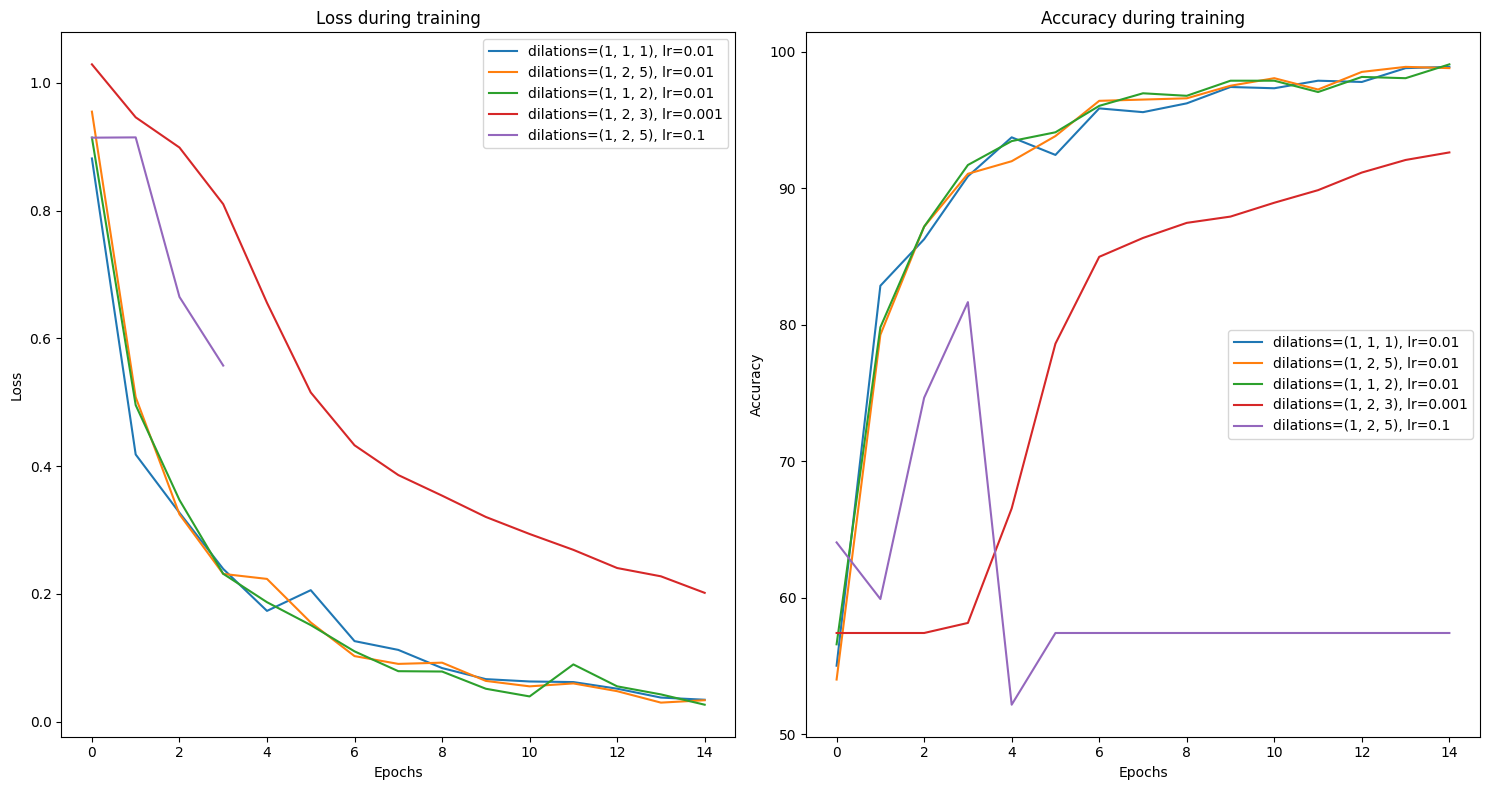

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据
def load_data(data_dir, test_size=0.2):
    labels = {'car': 0, 'bus': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# 定义空洞卷积神经网络（支持多层空洞卷积）
class DilatedConvNet(nn.Module):
    def __init__(self, dilation_rates=[1, 2, 5]):
        super(DilatedConvNet, self).__init__()
        
        self.conv_layers = nn.ModuleList()
        in_channels = 3
        
        # 使用不同dilation值创建空洞卷积层
        for dilation in dilation_rates:
            self.conv_layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, dilation=dilation, padding=dilation))
            in_channels = 64  # 每一层卷积后输出通道数固定为64
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # 计算卷积后输出的维度，用于全连接层
        self._dummy_input = torch.zeros(1, 3, 128, 128)
        self._out_channels = 64
        self._conv_output_size = self._get_conv_output(self._dummy_input)
        
        self.fc1 = nn.Linear(self._conv_output_size, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def _get_conv_output(self, shape):
        # 假设输入的shape是 (batch_size, channels, height, width)
        x = shape
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))
        # 返回展平后的维度
        return int(np.prod(x.size()))

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(torch.relu(conv(x)))  # 每个空洞卷积层 + ReLU 激活 + 池化
        
        x = x.view(x.size(0), -1)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 训练函数
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        start_time = time.time()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    return loss_history, accuracy_history

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

# 使用DataLoader加载训练集和测试集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 选择不同的超参数组合进行实验
params = [
    {"dilation_rates": [1, 1, 1], "lr": 0.01},  # 相同的dilation 1，学习率0.01
    {"dilation_rates": [1, 2, 5], "lr": 0.01},  # HDC dilation 1, 2, 5，学习率0.01
    {"dilation_rates": [1, 1, 2], "lr": 0.01},  # 不同的dilation，学习率0.01
    {"dilation_rates": [1, 2, 3], "lr": 0.001}, # dilation 1, 2, 3，学习率0.001
    {"dilation_rates": [1, 2, 5], "lr": 0.1}    # dilation 1, 2, 5，学习率0.1
]

# 存储训练结果
results = {}

# 对每种组合进行训练
for param in params:
    print(f"\nTraining model with dilation rates {param['dilation_rates']} and lr = {param['lr']}")
    
    # 初始化模型、损失函数和优化器
    model = DilatedConvNet(dilation_rates=param["dilation_rates"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=param["lr"], momentum=0.9)

    # 训练模型
    loss_history, accuracy_history = train_model(train_loader, test_loader, model, criterion, optimizer, epochs=15)
    
    # 存储训练结果
    results[(tuple(param["dilation_rates"]), param["lr"])] = (loss_history, accuracy_history)

# 绘制训练结果图
def plot_training_history(results):
    plt.figure(figsize=(15, 8))

    for (dilation_rates, lr), (loss_history, accuracy_history) in results.items():
        label = f"dilations={dilation_rates}, lr={lr}"
        
        # 绘制损失曲线
        plt.subplot(1, 2, 1)
        plt.plot(loss_history, label=label)

        # 绘制准确率曲线
        plt.subplot(1, 2, 2)
        plt.plot(accuracy_history, label=label)

    plt.subplot(1, 2, 1)
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制不同超参数的训练结果
plot_training_history(results)